# Poseidon Project

The sailboat model implemented in this notebook is based on the system presented in [Modeling, control and state-estimation for an autonomous sailboat](https://uu.diva-portal.org/smash/get/diva2:850625/FULLTEXT01.pdf).

The model uses the *North-East-Up* (NED) coordinate system as inertial reference frame (*n-frame*). The body fixed frame (*b-frame*) is defined as a rotating frame as indicated in the following figure.

![figure1](./images/sailboat-02.png)
<center><b>Figure 1: </b> <i> Sailboat model reference frames and variables </i></center>

In [1]:
using Plots
gr()

βb = 0.05   #boat’s drift coefficient
cfw_l = 60.  #water tangetial friction
cfw_a = 500. #water angular friction
λs  = 500.  #lift coefficient of the sail
λr  = 300.  #lift coefficient of the rudder
ρmc = 1.    #distance between the mast and the center of the sail
ρgm = 1.    #distance between the boat’s center of gravity and the mast
ρgr = 2.    #distance between G and the rudder
mass  = 1000. #total mass of the boat (including the added-mass)
Jz  = 2000. #moment of inertia

p1 = βb
p2 = cfw_l
p3 = cfw_a
p4 = λs
p5 = λr
p6 = ρmc
p7 = ρgm
p8 = ρgr
p9 = mass
p10 = Jz
p11 = 0.2;

In [2]:
function sailboat_model(z::Array{Float64,1}, cmd::Array{Float64,1}, vtw::Float64, ψtw::Float64)
   
    x = z[1]
    y = z[2]
    θ = z[3]
    v = z[4]
    w = z[5]
    
    δs = cmd[1]
    δr = cmd[2]
    
    fsail, frudder = forces(z, cmd,  vtw, ψtw)
    
    dx = v * cos(θ) + p1 * vtw * cos(ψtw)
    dy = v * sin(θ) + p1 * vtw * sin(ψtw)
    dθ = w
    dv = 1/p9 * (fsail * sin(δs) - p11 * frudder * sin(δr) - p2 * v^2)
    dw = 1/p10 * ((p6 - p7 * cos(δs)) * fsail - p8 * frudder * cos(δr) - p3 * w * v)
    
    dz = [dx, dy, dθ, dv, dw]
    
end

function forces(z::Array{Float64,1}, cmd::Array{Float64,1}, vtw::Float64, ψtw::Float64)

    θ = z[3]
    v = z[4]
    
    δs = cmd[1]
    δr = cmd[2]
    
    tmp_wind = [vtw * cos(ψtw - θ) - v, vtw * sin(ψtw - θ)]
    vaw = norm(tmp_wind)
    ψaw = atan2(tmp_wind[2], tmp_wind[1])
    
    fsail = p4 * vaw * sin(δs - ψaw)
    frudder = p5 * v * sin(δr)
    
    return fsail, frudder
    
end

function compute_cmd(z::Array{Float64,1}, vtw::Float64, ψtw::Float64, q::Float64)
    
    x = z[1]
    y = z[2]
    θ = z[3]
    v = z[4]
    w = z[5]
    
    p = [x, y]'
    
    tmp = (b-a)/norm(b-a)
    tmp = vcat(tmp, p-a)
    e = det(tmp)
    if abs(e) > 1.5 * r
        q = sign(e)
    end 

    β = atan2(b[2]-a[2], b[1]-a[1])
    θref = β - 2 * γ_inf / π * atan(e / r)
    θref = atan2(sin(θref), cos(θref))

    if ((cos(ψtw - θref) + cos(ζ)) < 0.)       
        θref = π + ψtw - q * ζ
        θref = atan2(sin(θref), cos(θref))
    end
        
    eθ = θ - θref
    eθ = atan2(sin(eθ), cos(eθ))
    
    δrmax = π/9
    if cos(eθ) >= 0.
        δr = δrmax * sin(eθ)
    else
        δr = δrmax * sign(sin(eθ))
    end
    
    δr = 1. * eθ + 1.75 * w
    if(abs(δr) > δrmax)
        δr = sign(δr) * δrmax
    end
    
    tmp_wind = [vtw * cos(ψtw - θ) - v, vtw * sin(ψtw - θ)]
    vaw = norm(tmp_wind)
    ψaw = atan2(tmp_wind[2], tmp_wind[1])
    
    δsmin = π/32
    δsmax = π/5.2
    δs = - sign(ψaw) * ((δsmin-δsmax) * abs(ψaw) / π + δsmax)
    
    #δs = π/2 * (cos(ψtw - θ) + 1)/2
    
    cmd = [δs, δr]
    
    return cmd, θref, q
    
end

compute_cmd (generic function with 1 method)

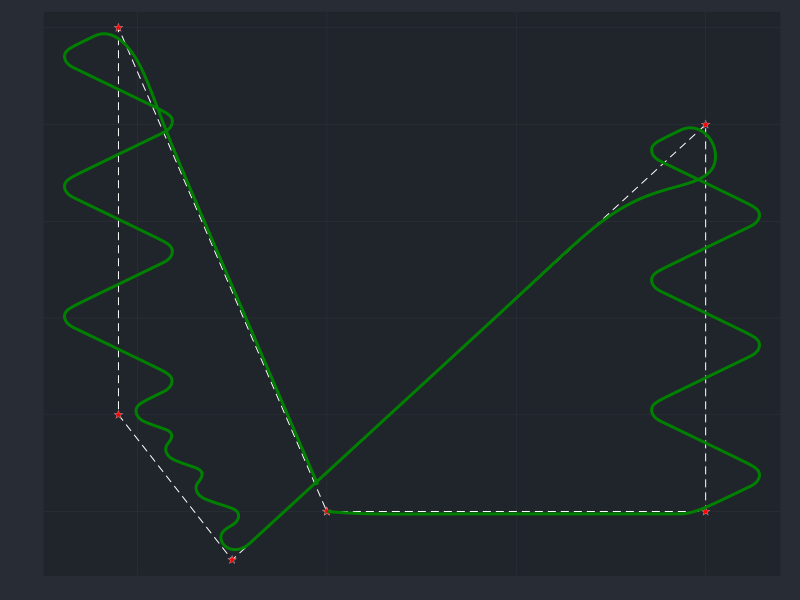

In [3]:
#initial conditions
x0 = 0.
y0 = 0.
θ0 = deg2rad(0.)
u0 = 5.
r0 = 0.
δs0 = 0.
δr0 = 0.

x_ = [x0]
y_ = [y0]
θ_ = [θ0]
u_ = [u0]
r_ = [r0]
δs_ = [δs0]
δr_ = [δr0]
z = [x_[end], y_[end], θ_[end], u_[end], r_[end]]
z[3] = atan2(sin(z[3]), cos(z[3]))

#actuators force
fr_ = [0.]
fs_ = [0.]
θref_ = [0.]

vtw = 7.0  #wind true speed
ϕtw = deg2rad(-90.) #wind true heading

time_  = 0. 
dt = 0.1
q = 1.

r = 15.
γ_inf = π/3
ζ = π/3

#goal position
k = 1
xd = [0., 200., 200., -50., -110., -110, 0.]
yd = [0., 0.,   200., -25.,   50., 250., 0.]
zd = [xd[k+1], yd[k+1], 0., 0., 0., 0., 0.]

a = [xd[k], yd[k]]'
b = [xd[k+1], yd[k+1]]'

err = norm([x_[end], y_[end]] - b')
while k < size(xd)[1]

    cmd, θref, q = compute_cmd(z, vtw, ϕtw, q)    
    z += sailboat_model(z, cmd, vtw, ϕtw) * dt
    z[3] = atan2(sin(z[3]), cos(z[3]))
    
    push!(x_,z[1])
    push!(y_,z[2])
    push!(θ_,z[3])
    push!(u_,z[4])
    push!(r_,z[5])
    push!(δs_,cmd[1])
    push!(δr_,cmd[2])
    
    fs_tmp, fr_tmp = forces(z, cmd, vtw, ϕtw)
    
    push!(fs_, fs_tmp)
    push!(fr_, fr_tmp)
    push!(θref_, θref)

    time_ = time_ + dt
    err = norm([x_[end], y_[end]] - b')
    if err < r
        k += 1
        if k < size(xd)[1]
            a = [xd[k], yd[k]]'
            b = [xd[k+1], yd[k+1]]'
        end
    end    
end

theme(:juno)
plot(xd, yd, marker = (:star, :red), line = (:white, :dash))
plt1 = plot!(x_, y_, legend = false, axis = false, line = (3, :green), size = (800, 600))

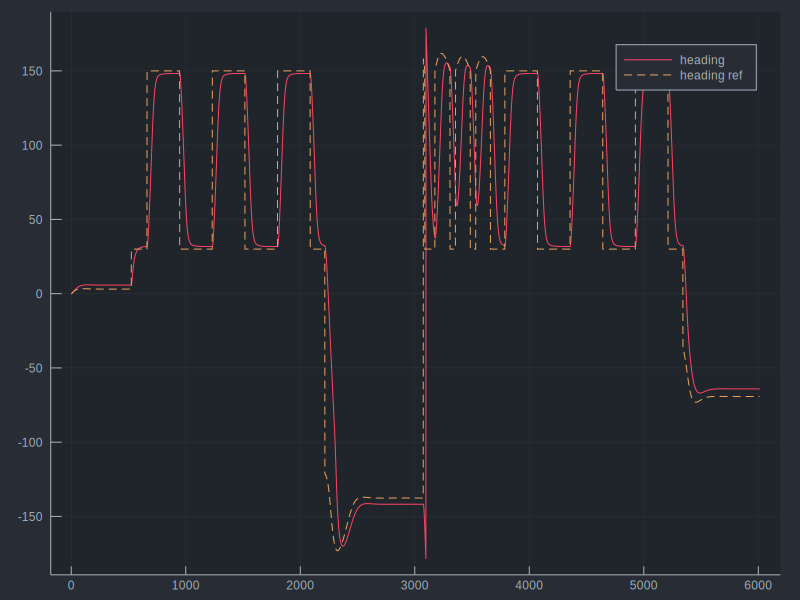

In [4]:
savefig("sailboat-trajectory.png")
plt2 = plot([θ_, θref_] * 180 /π, line = ([:solid :dash]), label = ["heading" "heading ref"], size = (800, 600))

In [5]:
savefig("sailboat-heading.png")